In [2]:
import os
import pyspark
from pyspark.sql import SparkSession
import findspark
from functools import reduce
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, unix_timestamp, dayofweek, dayofmonth, udf, hour, minute, unix_timestamp, concat_ws
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
spark = SparkSession.builder.appName("Predict price").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/30 09:48:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Relative path
rel_path = "../TOMAS/projeto_principal/full_dataset_after_cleaning.parquet"

# Get absolute path
abs_path = os.path.abspath(rel_path)

# Load the dataset
data = spark.read.parquet(abs_path)

In [5]:
print(data.count())
data.printSchema()

21345357
root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- pickup_hour_decimal: double (nullabl

In [6]:
# Extract day of week
df = data.withColumn("day", dayofmonth("tpep_pickup_datetime")) \
    .withColumn("hour", hour("tpep_pickup_datetime")) \
    .withColumn("day_of_week", dayofweek("tpep_pickup_datetime"))

df = df.select(["trip_distance", 
               "total_amount", 
               "is_holiday", 
               "is_weekend", 
               "month", 
            #    "day",
               "day_of_week",
               "hour", 
            #    "passenger_count",
               "is_shared_ride",
               "Airport_fee"])
df.show(5)

+-------------+------------+----------+----------+-----+-----------+----+--------------+-----------+
|trip_distance|total_amount|is_holiday|is_weekend|month|day_of_week|hour|is_shared_ride|Airport_fee|
+-------------+------------+----------+----------+-----+-----------+----+--------------+-----------+
|          0.6|        12.1|         0|         0|    8|          4|   2|             0|          0|
|          8.5|       61.84|         0|         0|    7|          3|  17|             1|          0|
|         4.16|        31.8|         0|         0|    7|          6|  17|             1|          0|
|          2.0|        27.2|         0|         0|    7|          4|  22|             0|          0|
|         0.79|       14.64|         0|         0|    9|          2|  21|             0|          0|
+-------------+------------+----------+----------+-----+-----------+----+--------------+-----------+
only showing top 5 rows



In [10]:
for feature in df.columns[2:]:
    df.groupBy(feature).avg("total_amount").orderBy(feature).show()

+----------+------------------+
|is_holiday| avg(total_amount)|
+----------+------------------+
|         0| 29.19127313147785|
|         1|30.506951848017646|
+----------+------------------+

+----------+------------------+
|is_weekend| avg(total_amount)|
+----------+------------------+
|         0|29.602414046344965|
|         1|27.871996403089646|
+----------+------------------+

+-----+------------------+
|month| avg(total_amount)|
+-----+------------------+
|    1| 27.83849305979868|
|    2| 27.83260180472908|
|    3|28.584379590315496|
|    4|  28.8638309025746|
|    5|29.584601099084438|
|    6| 29.36256074911373|
|    7| 29.59313385400771|
|    8|29.681304602223488|
|    9|30.131400452506316|
|   10|29.863175687122773|
|   11|29.032758722192987|
|   12|29.886593407691475|
+-----+------------------+



+-----------+------------------+
|day_of_week| avg(total_amount)|
+-----------+------------------+
|          1|29.569050779591038|
|          2|30.731664691118368|
|          3| 29.33905972456355|
|          4| 29.40812622252625|
|          5|29.836560223476212|
|          6| 28.91820418567616|
|          7| 26.47098276167331|
+-----------+------------------+

+----+------------------+
|hour| avg(total_amount)|
+----+------------------+
|   0|  26.9375828721586|
|   1|24.692477772435232|
|   2|23.593400882185406|
|   3|24.356048317104854|
|   4|29.415971067100227|
|   5| 32.36270080117651|
|   6|31.596833338184865|
|   7| 30.65892762644665|
|   8|31.111521055903623|
|   9|32.870594798147636|
|  10|34.036634105565014|
|  11| 33.35002922925061|
|  12| 33.72119859482227|
|  13| 34.20065966004509|
|  14| 35.42419020723544|
|  15| 34.77540834791939|
|  16| 32.81180706221667|
|  17|30.389600763857022|
|  18|28.796971969827222|
|  19|28.964577010084536|
+----+------------------+
only showing

Include: 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee'

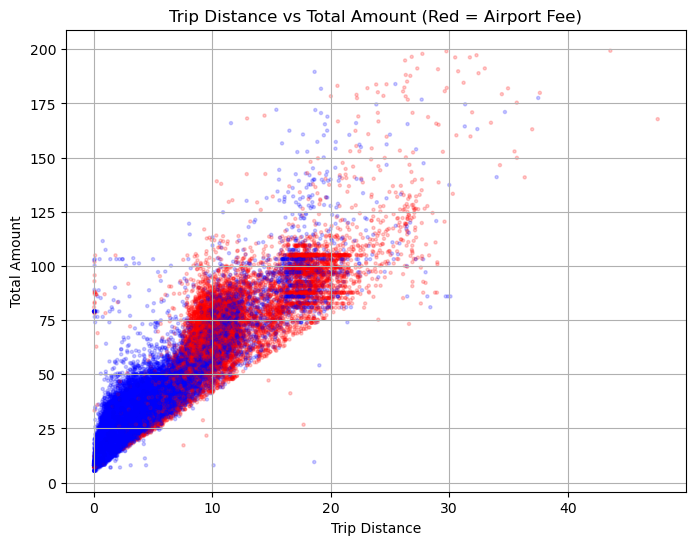

In [13]:
# Select the data including Airport_fee
pandas_df = df.select(["trip_distance", "total_amount", "Airport_fee"]) \
              .limit(100000).toPandas()

# Define colors: red if Airport_fee == 1, else blue
colors = pandas_df['Airport_fee'].apply(lambda x: 'red' if x == 1 else 'blue')

plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['trip_distance'], pandas_df['total_amount'], c=colors, alpha=0.2, s=5)
plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title("Trip Distance vs Total Amount (Red = Airport Fee)")
plt.grid(True)
plt.show()

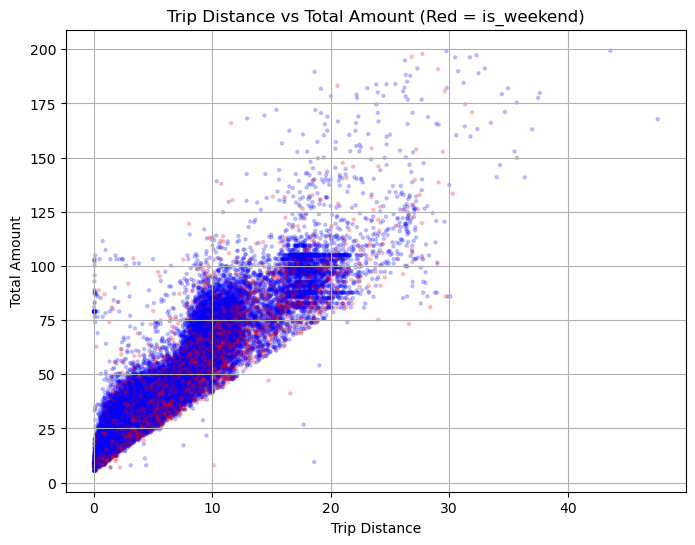

In [15]:
col = 'is_weekend' #'is_holiday' #'is_shared_ride' 
pandas_df = df.select(["trip_distance", "total_amount", col]) \
              .limit(100000).toPandas()

# Define colors: red if col == 1, else blue
colors = pandas_df[col].apply(lambda x: 'red' if x == 1 else 'blue')

plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['trip_distance'], pandas_df['total_amount'], c=colors, alpha=0.2, s=5)
plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title(f"Trip Distance vs Total Amount (Red = {col})")
plt.grid(True)
plt.show()

In [50]:
# no need for indexer as all values doubles or integers
df.printSchema()

root
 |-- trip_distance: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- is_shared_ride: integer (nullable = true)



In [16]:
assembler = VectorAssembler(inputCols=['trip_distance'],
outputCol='features')
df = assembler.transform(df)

assembler2 = VectorAssembler(inputCols=['trip_distance',
    #'is_holiday',
    #'is_weekend',
    #'month',
    'day_of_week',
    'hour',
    'is_shared_ride',
    'Airport_fee'], 
outputCol='features2')
df = assembler2.transform(df)

In [17]:
# Split data
train_data, test_data = df.select(['features', 'features2', 'total_amount']).randomSplit([0.8, 0.2], seed=42)

In [14]:
# Define Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="total_amount")

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate model
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Show results
print(f"Root Mean Squared Error (RMSE): {rmse}")
predictions.select("features", "total_amount", "prediction").show(10)

# Model coefficients and intercept
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

25/04/30 09:26:03 WARN Instrumentation: [f3783184] regParam is zero, which might cause numerical instability and overfitting.


CodeCache: size=131072Kb used=33358Kb max_used=33645Kb free=97713Kb
 bounds [0x000000010a18c000, 0x000000010c28c000, 0x000000011218c000]
 total_blobs=12953 nmethods=11889 adapters=976
 compilation: disabled (not enough contiguous free space left)


OpenJDK 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
OpenJDK 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=
25/04/30 09:26:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/30 09:26:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Squared Error (RMSE): 6.9324479817549625


+--------+------------+------------------+
|features|total_amount|        prediction|
+--------+------------+------------------+
|  [0.01]|         8.0|12.815402025826245|
|  [0.01]|         8.7|12.815402025826245|
|  [0.01]|         8.0|12.815402025826245|
|  [0.01]|         8.0|12.815402025826245|
|  [0.01]|         5.5|12.815402025826245|
|  [0.01]|        25.0|12.815402025826245|
|  [0.01]|         8.0|12.815402025826245|
|  [0.01]|         9.5|12.815402025826245|
|  [0.01]|        10.9|12.815402025826245|
|  [0.01]|         7.0|12.815402025826245|
+--------+------------+------------------+
only showing top 10 rows

Coefficients: [4.901608797794171]
Intercept: 12.766385937848304


In [23]:
rf = RandomForestRegressor(featuresCol="features", labelCol="total_amount")

# Train
model = rf.fit(train_data)

25/04/29 13:05:03 WARN MemoryStore: Not enough space to cache rdd_78_0 in memory! (computed 8.3 MiB so far)
25/04/29 13:05:03 WARN MemoryStore: Not enough space to cache rdd_78_7 in memory! (computed 8.3 MiB so far)
25/04/29 13:05:03 WARN BlockManager: Persisting block rdd_78_0 to disk instead.
25/04/29 13:05:03 WARN BlockManager: Persisting block rdd_78_7 to disk instead.
25/04/29 13:05:03 WARN MemoryStore: Not enough space to cache rdd_78_4 in memory! (computed 8.3 MiB so far)
25/04/29 13:05:03 WARN BlockManager: Persisting block rdd_78_4 to disk instead.
25/04/29 13:05:03 WARN MemoryStore: Not enough space to cache rdd_78_6 in memory! (computed 8.3 MiB so far)
25/04/29 13:05:03 WARN BlockManager: Persisting block rdd_78_6 to disk instead.
25/04/29 13:05:03 WARN MemoryStore: Not enough space to cache rdd_78_2 in memory! (computed 8.3 MiB so far)
25/04/29 13:05:03 WARN BlockManager: Persisting block rdd_78_2 to disk instead.
25/04/29 13:05:03 WARN MemoryStore: Not enough space to cach

In [24]:
# Predict
predictions = model.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse:.2f}")

RMSE: 6.76


In [18]:
rf2 = RandomForestRegressor(featuresCol="features2", labelCol="total_amount")

# Train
model2 = rf2.fit(train_data)

25/04/30 09:56:32 WARN MemoryStore: Not enough space to cache rdd_168_3 in memory! (computed 12.0 MiB so far)
25/04/30 09:56:32 WARN MemoryStore: Not enough space to cache rdd_168_7 in memory! (computed 12.0 MiB so far)
25/04/30 09:56:32 WARN MemoryStore: Not enough space to cache rdd_168_2 in memory! (computed 12.0 MiB so far)
25/04/30 09:56:32 WARN BlockManager: Persisting block rdd_168_7 to disk instead.
25/04/30 09:56:32 WARN BlockManager: Persisting block rdd_168_2 to disk instead.
25/04/30 09:56:32 WARN BlockManager: Persisting block rdd_168_3 to disk instead.
25/04/30 09:56:32 WARN MemoryStore: Not enough space to cache rdd_168_6 in memory! (computed 18.5 MiB so far)
25/04/30 09:56:32 WARN BlockManager: Persisting block rdd_168_6 to disk instead.
25/04/30 09:56:32 WARN MemoryStore: Not enough space to cache rdd_168_0 in memory! (computed 18.5 MiB so far)
25/04/30 09:56:32 WARN BlockManager: Persisting block rdd_168_0 to disk instead.
25/04/30 09:56:32 WARN MemoryStore: Not enoug

In [19]:
# Predict
predictions2 = model2.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions2)
print(f"RMSE: {rmse:.2f}")

RMSE: 7.69


In [23]:
# Extract feature importances
# 'trip_distance', 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee'
importances = model2.featureImportances
importances

SparseVector(5, {0: 0.6799, 1: 0.0018, 2: 0.012, 3: 0.0002, 4: 0.3061})

In [ ]:
# Predict with many features
predictions2 = model2.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions2)
print(f"RMSE: {rmse:.2f}")

RMSE: 7.85
